In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns
%config InlineBackend.figure_format = 'svg' 

from pylab import rcParams
rcParams['figure.figsize'] = 9,6

## Rosbank ML Competition

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
4. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
5. **Дополнительная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
6. Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe

In [2]:
raw_df = pd.read_csv('FE 3/rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
raw_df['currency'][raw_df['currency']==810].count()

477644

Для начала возьмем некоторое категориальных количество фич и с помощью One Hot Encoding преобразуем категориальные переменные в форму, которая может быть предоставлена алгоритмам ML для лучшей работы в прогнозировании.

In [4]:
def get_one_hot(df, cols):
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
    return df

In [5]:
raw_df1 = raw_df.iloc[:, :-2]

Используем One Hot Encoding для таких категорий как 'trx_category', 'channel_type', 'MCC'.

In [6]:
raw_df1 = get_one_hot(raw_df1, ['trx_category', 'channel_type', 'MCC'])

Удалим категориальные признаки.

In [7]:
raw_df1 = raw_df1.drop(raw_df1.columns[[7, 5, 3, 0]], axis=1)

In [8]:
X = raw_df1.as_matrix()
y = raw_df.target_flag

Используем логистическую регрессию для нашей модели.

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
clf = LogisticRegression()

In [11]:
clf.fit(X=X, y=y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve
y_train_predict = clf.predict_proba(X)[:, 1]


roc_auc_train = np.round(roc_auc_score(y, y_train_predict), 9)
print("Train: ", round(roc_auc_train, 2))

Train:  0.75


Видно, что для данного количества фич наш результат получился 0.75, теперь попробуем выбрать более грамотно фичи и увеличить точность модели.

In [13]:
raw_df.info('TRDATETIME')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [14]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [15]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [16]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  389343
Total transactions in test dataset:  101170


## Практика

In [17]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

C:\Users\Arsenii\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [18]:
transactions_train_lm = transactions_train.drop(['TRDATETIME', 'trx_category', 'channel_type'], axis=1)

In [19]:
_iteration_cols = transactions_train_lm.columns.drop('target_flag')

In [20]:
def get_formula(_cols):
    return 'target_flag ~ ' + " + ".join(_cols)

In [21]:
get_formula(_iteration_cols)

'target_flag ~ PERIOD + cl_id + MCC + currency + amount + target_sum'

In [22]:
lm = smf.ols(get_formula(_iteration_cols), transactions_train_lm).fit()
rss = np.sum(lm.resid ** 2)
rmse = np.sqrt(rss / len(lm.resid))
print("RMSE:", rmse)
print("R^2:", lm.rsquared)

RMSE: 0.4325558411782234
R^2: 0.174660468282964


Таким образом, видно, что данные без 'TRDATETIME', 'trx_category', 'channel_type' данные объясняют лишь 17% дисперсии. Таким образом их имеет смысл учитывать при построенни модели.

In [23]:
lm_res = lm.summary()
lm_res.tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.0109,0.016,64.742,0.000,0.980,1.042
PERIOD[T.01/01/2018],-0.0094,0.009,-1.100,0.271,-0.026,0.007
PERIOD[T.01/02/2017],0.0262,0.003,7.705,0.000,0.020,0.033
PERIOD[T.01/02/2018],-0.0532,0.010,-5.489,0.000,-0.072,-0.034
PERIOD[T.01/03/2017],0.0313,0.003,9.011,0.000,0.024,0.038
PERIOD[T.01/03/2018],-0.0629,0.010,-6.167,0.000,-0.083,-0.043
PERIOD[T.01/04/2017],-0.0098,0.003,-2.974,0.003,-0.016,-0.003
PERIOD[T.01/04/2018],-0.0365,0.073,-0.498,0.618,-0.180,0.107
PERIOD[T.01/05/2017],-0.0162,0.003,-4.973,0.000,-0.023,-0.010
PERIOD[T.01/06/2017],-0.0144,0.003,-4.549,0.000,-0.021,-0.008


In [24]:
transactions_train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


**Обязательная часть: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи**

Посмотрим долю транзакций в рублях, среди всех транзакций. 

In [25]:
transactions_train['currency'][transactions_train['currency']==810].count()/transactions_train['currency'].count()

0.9723893841676876

Таким образом, более 97 процентов транзакций проходят в рублях. 

- Постоим некоторые распределения. Для интереса, можно проверить как распределена сумма всех транзакций. 

C:\Users\Arsenii\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


Text(0.5,0,'$x$')

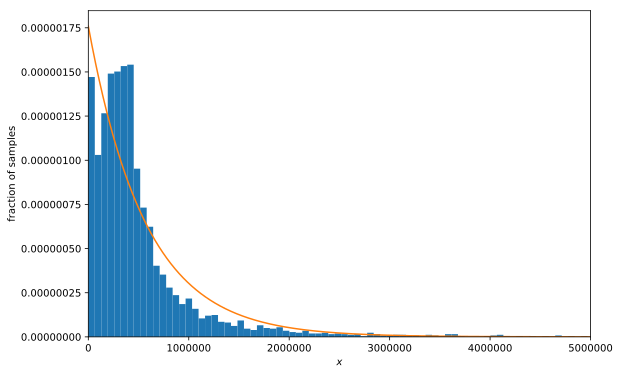

In [75]:
amount = transactions_train[['cl_id', 'amount']].groupby('cl_id').sum()
from scipy import stats

x = amount['amount']
sp = np.linspace(0, 5e6, 1e5)
pdf = stats.expon(scale=x.mean()).pdf(sp)
plt.hist(x, density=True, bins=1000)
plt.plot(sp, pdf)
plt.xlim(0, 5e6)
plt.ylabel('fraction of samples')
plt.xlabel('$x$')

Видно, что распределение очень похоже на экспоненциальное.

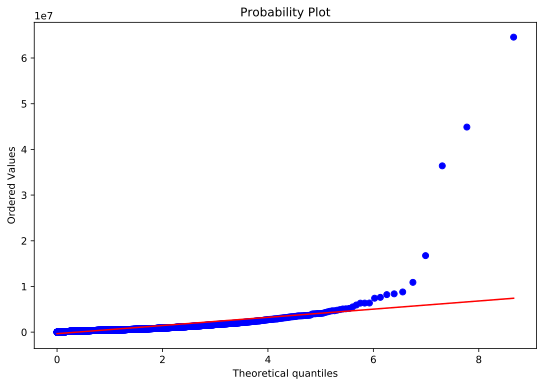

In [76]:
res = stats.probplot(x, plot=plt, dist='expon')

qq-plot подтверждает то, что сумма транзакций распределена по экспоненциальному расперделению, за исключением некоторых выбросов.

Посмотрим некоторые корреляции между параметрами. 

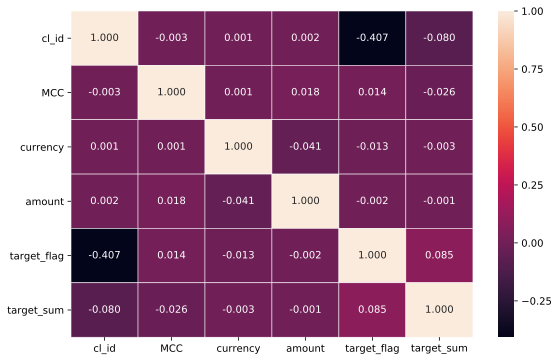

In [77]:
corr = transactions_train.corr()
sns.heatmap(corr, annot=True, fmt=".3f", 
            linewidths=0.5);

Видно, что корреляция между target_flag и другими параметрами не сильно выражена, за исключением cl_id.

Посмотрим каким МСС наиболее популярны. 

In [29]:
transactions_train_MCC_count = transactions_train[['cl_id', 'MCC']].groupby('MCC').count()
transactions_train_MCC_count = transactions_train_MCC_count.rename(index=str, columns={'cl_id': 'count'})
TOP_5_MCC_list = list(transactions_train_MCC_count.sort_values('count', ascending=False).iloc[:5, :].index)

In [30]:
print('Коды наиболее популярных МСС: ', TOP_5_MCC_list)

Коды наиболее популярных МСС:  ['5411', '6011', '5814', '5812', '5499']


Найдем долю наиболее популярных МСС во всех транзакциях.

In [31]:
transactions_train_MCC_count.sort_values('count', ascending=False).iloc[:5, :]/transactions_train_MCC_count.sum()

,count
MCC,
5411,0.247640
6011,0.110032
5814,0.085611
5812,0.061319
5499,0.055270


Видно, что на первые 5 МСС приходится более 50% всех транзакций.

Теперь посмотрим непосредственно, что это за транзакции, которые скрываются за данными кодами.

In [32]:
from bs4 import BeautifulSoup as bs
# import requests
import urllib
from urllib.request import urlopen, Request

In [33]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.3'
}
reg_url = 'https://mcc-codes.ru/code'
req = Request(url=reg_url, headers=headers)

In [34]:
check = bs(urlopen(req).read())

C:\Users\Arsenii\AppData\Local\Continuum\anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\Arsenii\AppData\Local\Continuum\anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [35]:
list_of_mcc_tags = check.find_all('tr')[1:]

In [36]:
mcc_names_list = list(
    map(
        lambda x: (x.text.split('\n')[1], x.text.split('\n')[2]), list_of_mcc_tags
    )
)

In [37]:
mcc_names_DF = pd.DataFrame(mcc_names_list)
mcc_names_DF = mcc_names_DF.rename(columns={0:'MCC', 1: 'Name'})

In [38]:
for i in TOP_5_MCC_list:
    print(mcc_names_DF[mcc_names_DF['MCC']==i]['Name'])

765    Бакалейные магазины, супермаркеты
Name: Name, dtype: object
863    Финансовые учреждения – снятие наличности авто...
Name: Name, dtype: object
812    Фастфуд
Name: Name, dtype: object
810    Места общественного питания, рестораны
Name: Name, dtype: object
772    Различные продовольственные магазины - нигде б...
Name: Name, dtype: object


Основа всех транзакций - магазины, что в общем-то логично.

In [39]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
    
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()

In [40]:
transaction_by_day_count = transaction_by_day_count(transactions_train)

In [41]:
transaction_by_hour_count = transaction_by_hour_count(transactions_train)

Посмотрим, какое количество количество транзакций были совершены в какое время. 

In [42]:
transaction_by_hour_count.sum().sort_values(ascending=False)

hour_of_transaction
cl_id    20313811.0
00         343482.0
13           3817.0
11           3765.0
12           3732.0
14           3501.0
15           3256.0
10           3242.0
16           3068.0
17           3064.0
09           2915.0
18           2909.0
19           2163.0
08           2148.0
07           1515.0
20           1455.0
21           1045.0
06           1030.0
05            754.0
22            689.0
04            521.0
23            409.0
03            366.0
02            297.0
01            200.0
dtype: float64

Видно, что основная масса транзакций совершена в дневное время. При этом есть совершенно выраженный максимум в 00, вероятно это связано с банковской системой регистрации времени. 

In [43]:
transaction_by_day_count.sum().sort_values(ascending=False)

day_of_transaction
cl_id    20313811.0
day_5       62731.0
day_6       58864.0
day_4       56763.0
day_3       55124.0
day_2       54218.0
day_1       52364.0
day_0       49279.0
dtype: float64

Что касается дней, когда были совершены транзакции то можно сказать, что распределение близко к равномерному, но суббота является днем с максимальным количеством транзакций.

In [44]:
transaction_by_day_count_sum = pd.DataFrame(transaction_by_day_count.sum())
transaction_by_day_count_sum = transaction_by_day_count_sum.rename(columns={0:'sum'})
transaction_by_day_count_sum = transaction_by_day_count_sum.drop(transaction_by_day_count_sum.index[[0]])

Проверим на равномерность с помощью qq-plot'a.

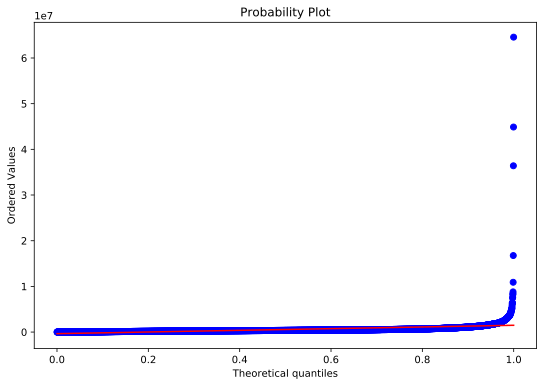

In [78]:
res = stats.probplot(x, plot=plt, dist='uniform')

Видно, что равномерность, действительно присутсвует с достаточной точностью.

Посмотрим, какие категории транзакции (trx_category) наиболее популярны.

In [46]:
transactions_train_trx_count = transactions_train[['cl_id', 'trx_category']].groupby('trx_category').count()
transactions_train_trx_count = transactions_train_trx_count.rename(index=str, columns={'cl_id': 'count'})
transactions_train_trx = transactions_train_trx_count.sort_values('count', ascending=False)/transactions_train_trx_count.sum()

In [47]:
transactions_train_trx

,count
trx_category,
POS,0.849788
DEPOSIT,0.043119
WD_ATM_ROS,0.038914
WD_ATM_PARTNER,0.020108
C2C_IN,0.014838
WD_ATM_OTHER,0.014129
C2C_OUT,0.011103
BACK_TRX,0.005455
CAT,0.002468


Text(0.5,1,'Распределение trx категорий в по их доле во всех транзакциях.')

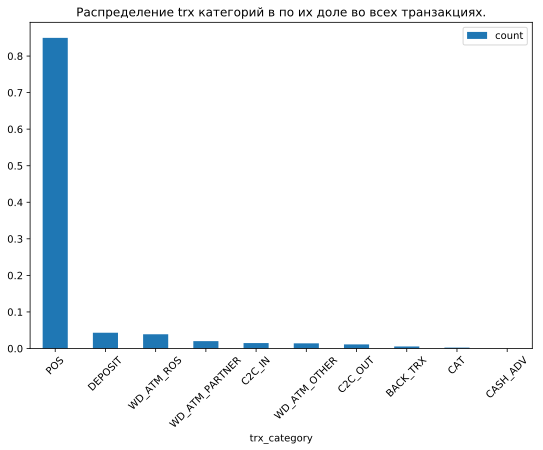

In [79]:
transactions_train_trx.plot(kind='bar', rot=45)
plt.title('Распределение trx категорий в по их доле во всех транзакциях.')

Видно, что категория POS является преобладающей (около 85 процентов) 

Теперь займемся отбором фичей.

In [49]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [50]:
len(transactions_train['MCC'].unique())*2

664

Будем использовать функцию get_aggregated_df, чтобы агрегировать фичи суммированием и поиском среднего. Затем смержим их и добавим все в один датафрейм. 

In [51]:
df_train_mcc = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

In [52]:
df_train_trx_category = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

In [53]:
df_train_mcc = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='MCC'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='MCC'),
    left_index=True,
    right_index=True,
)

df_train_trx_category = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='trx_category'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='trx_category'),
    left_index=True,
    right_index=True,
)

df_train = pd.merge(
    df_train_mcc,
    df_train_trx_category,
    left_index=True,
    right_index=True,
)

In [54]:
df_train.shape

(4000, 684)

Добавим еще одну фичу - сумму всех затрат по карте.

In [55]:
amount_sum_df = transactions_train[['cl_id', 'amount']].groupby('cl_id').sum()
amount_mean_df = transactions_train[['cl_id', 'amount']].groupby('cl_id').mean()

In [56]:
amount_df = pd.merge(amount_mean_df, amount_sum_df, left_index=True, right_index=True)

In [57]:
amount_df.shape

(4000, 2)

In [58]:
df_train = pd.merge(
    df_train,
    amount_sum_df,
    left_index=True,
    right_index=True,
    how='inner'
)

Сагрегируем аналогично колонку channel_type.

In [59]:
df_train_channel_type = pd.merge(
    get_aggregated_df(transactions_train, agg_type='mean', col_to_groupby='channel_type'),
    get_aggregated_df(transactions_train, agg_type='sum', col_to_groupby='channel_type'),
    left_index=True,
    right_index=True,
)

In [60]:
df_train = pd.merge(
    df_train,
    df_train_channel_type,
    left_index=True,
    right_index=True,
    how='inner'
)

In [61]:
df_targets = raw_df[['cl_id', 'target_flag']].drop_duplicates().copy()
df_targets.index = df_targets['cl_id']
df_targets = df_targets.drop('cl_id', axis=1)
df_targets.head()

,target_flag
cl_id,
0,0
1,0
5,1
9,0
10,0


In [62]:
df_train = pd.merge(
    df_train,
    df_targets,
    left_index=True,
    right_index=True,
    how='inner'
)

In [63]:
df_train.shape

(3979, 696)

Теперь построим модель. И проверим предсказательную силу с помощью двух классификаторов: XGB Classifier, Logistic Regression Classifier.

In [64]:
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost
from sklearn.linear_model import LogisticRegression

In [65]:
clf = LogisticRegression()
X_train = df_train.drop(['target_flag'], axis=1)
y_train = df_train['target_flag']

In [66]:
clf.fit(X=X_train, y=y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [81]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
# xgb = DecisionTreeClassifier()
xgb.fit(X_train, y_train)
y_train_predict = xgb.predict_proba(X_train)[:, 1]
roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.96


Построим график.

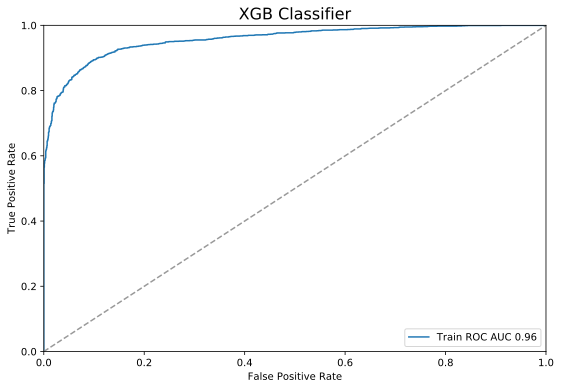

In [82]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)

plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

Теперь посмотрим на ROC AUC второго классификатора, который отражает его точность.

In [83]:
y_train_predict = clf.predict_proba(X_train)[:, 1]


roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 9)
print("Train: ", round(roc_auc_train, 2))

Train:  0.8


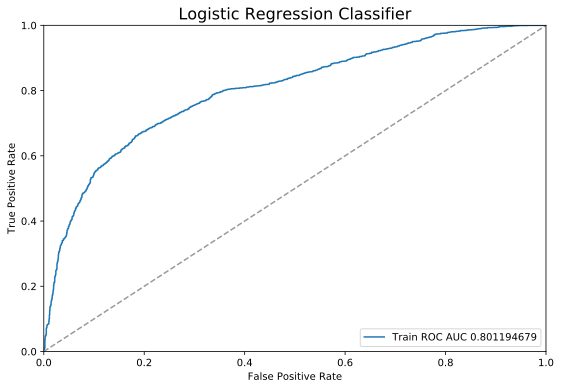

In [84]:
import matplotlib
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_predict)

plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Classifier', size=16)
plt.legend(loc='lower right')
plt.show()

In [85]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)
# xgb = DecisionTreeClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)